# Assignment 1

---

#### Name: 
#### Student ID: 

---

## Check python version >= 3.8

In [1]:
import sys
if not sys.version_info >= (3, 8):
    print("Python 3.8+ is required.")
    exit()

## Package used

In [2]:
from IPython.display import display

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import norm

from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Color map for confusion matrix

In [3]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["#fff4de",'#ffcb64',"#9ad7d2","#66aaa2"])

## Load preprocessed data

In [4]:
mushroom_data = pd.read_csv("../data/agaricus-lepiota.csv.xz").sample(frac=1).reset_index(drop=True)
display(mushroom_data.head())
iris_data = pd.read_csv("../data/iris.csv.xz").sample(frac=1).reset_index(drop=True)
display(iris_data.head())

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,label
0,f,f,n,t,n,f,c,b,w,t,...,g,p,p,w,o,p,n,y,d,e
1,k,f,w,f,n,f,w,b,w,e,...,w,w,p,w,t,p,w,s,g,e
2,x,y,g,f,f,f,c,b,p,e,...,n,b,p,w,o,l,h,y,d,p
3,x,f,g,t,n,f,c,b,p,t,...,w,p,p,w,o,p,k,y,d,e
4,f,s,n,f,s,f,c,n,b,t,...,w,p,p,w,o,e,w,v,p,p


,sepal length,sepal width,petal length,petal width,label
0,5.7,3.8,1.7,0.3,Iris-setosa
1,6.4,2.8,5.6,2.1,Iris-virginica
2,6.2,2.8,4.8,1.8,Iris-virginica
3,4.8,3.0,1.4,0.3,Iris-setosa
4,6.3,3.4,5.6,2.4,Iris-virginica


## Split features and labels

In [5]:
mushroom_feature = pd.get_dummies(mushroom_data.iloc[:, :-1], drop_first=True).to_numpy(dtype=np.int8)
mushroom_label = mushroom_data.iloc[:, -1].to_numpy(dtype="U1")
iris_feature = iris_data.iloc[:, :-1].to_numpy(dtype=np.float32)
iris_label = iris_data.iloc[:, -1].to_numpy(dtype="<U15")

mushroom_le = LabelEncoder()
iris_le = LabelEncoder()

mushroom_label = mushroom_le.fit_transform(mushroom_label)
iris_label = iris_le.fit_transform(iris_label)

## Function for drawing confusion matrix and reports

In [6]:
def generate_report(y_true, y_pred, le):
    matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot()
    dsp = ConfusionMatrixDisplay(matrix)

    dsp.plot(cmap=cmap, ax=ax, values_format='d')
    ax.set_xticklabels(le.classes_, ha='right')
    ax.set_yticklabels(le.classes_)
    fig.show()

    print("Accuracy: {:.6f}".format(accuracy_score(y_true, y_pred)))

    display(
        pd.DataFrame(
            (x.split()[1:] for x in [x for x in classification_report(y_true, y_pred).splitlines() if x][1:-3]),
            columns=['precision', 'recall', 'f1-score', 'support'],
            index=le.classes_
        )
    )


## Holdout validation

In [7]:
x_train_mushroom, x_test_mushroom, y_train_mushroom, y_test_mushroom = train_test_split(mushroom_feature, mushroom_label, test_size=0.3)
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(iris_feature, iris_label, test_size=0.3)

### Mushroom without Laplace smoothing

Accuracy: 0.996308


,precision,recall,f1-score,support
e,1.00,0.99,1.00,1289
p,0.99,1.00,1.00,1149


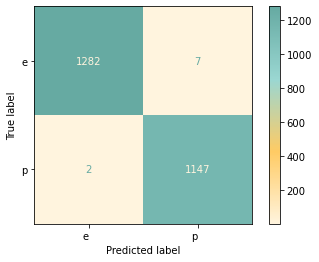

In [8]:
mushroom_without_laplace = CategoricalNB(alpha=0.0)
mushroom_without_laplace.fit(x_train_mushroom, y_train_mushroom)
y_pred = mushroom_without_laplace.predict(x_test_mushroom)
generate_report(y_test_mushroom, y_pred, mushroom_le)


### Mushroom with Laplace smoothing

Accuracy: 0.938474


,precision,recall,f1-score,support
e,0.90,0.99,0.94,1289
p,0.99,0.88,0.93,1149


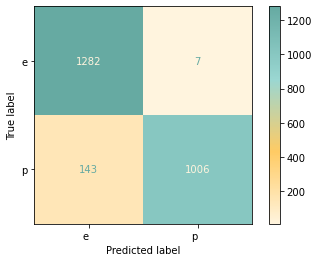

In [9]:
mushroom_with_laplace = CategoricalNB(alpha=1.0)
mushroom_with_laplace.fit(x_train_mushroom, y_train_mushroom)
y_pred = mushroom_with_laplace.predict(x_test_mushroom)
generate_report(y_test_mushroom, y_pred, mushroom_le)

### Iris

Accuracy: 1.000000


,precision,recall,f1-score,support
Iris-setosa,1.00,1.00,1.00,11
Iris-versicolor,1.00,1.00,1.00,19
Iris-virginica,1.00,1.00,1.00,15


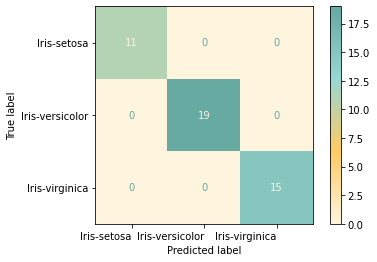

In [10]:
iris_model = GaussianNB()
iris_model.fit(x_train_iris, y_train_iris)
y_pred = iris_model.predict(x_test_iris)
generate_report(y_test_iris, y_pred, iris_le)

## K-fold cross-validation

In [11]:
kf = KFold(n_splits=3)

### Mushroom without Laplace smoothing 

Accuracy: 0.994830


,precision,recall,f1-score,support
e,1.00,0.99,0.99,4208
p,0.99,1.00,0.99,3916


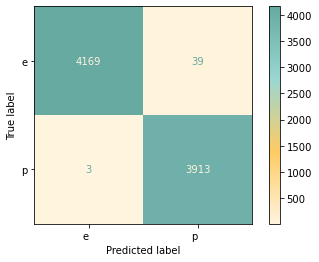

In [12]:
mushroom_without_laplace = CategoricalNB(alpha=0.0)
y_true = np.array([])
y_pred = np.array([])
for train_index, test_index in kf.split(mushroom_feature):
    x_train_mushroom, x_test_mushroom = mushroom_feature[train_index], mushroom_feature[test_index]
    y_train_mushroom, y_test_mushroom = mushroom_label[train_index], mushroom_label[test_index]
    mushroom_without_laplace.fit(x_train_mushroom, y_train_mushroom)
    y_true = np.append(y_true, y_test_mushroom)
    y_pred = np.append(y_pred, mushroom_without_laplace.predict(x_test_mushroom))
generate_report(y_true, y_pred, mushroom_le)

### Mushroom with Laplace smoothing 

Accuracy: 0.940423


,precision,recall,f1-score,support
e,0.90,0.99,0.95,4208
p,0.99,0.89,0.93,3916


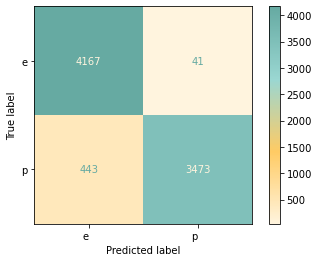

In [13]:
mushroom_with_laplace = CategoricalNB(alpha=1.0)
y_true = np.array([])
y_pred = np.array([])
for train_index, test_index in kf.split(mushroom_feature):
    x_train_mushroom, x_test_mushroom = mushroom_feature[train_index], mushroom_feature[test_index]
    y_train_mushroom, y_test_mushroom = mushroom_label[train_index], mushroom_label[test_index]
    mushroom_with_laplace.fit(x_train_mushroom, y_train_mushroom)
    y_true = np.append(y_true, y_test_mushroom)
    y_pred = np.append(y_pred, mushroom_with_laplace.predict(x_test_mushroom))
generate_report(y_true, y_pred, mushroom_le)

### Iris

Accuracy: 0.953333


,precision,recall,f1-score,support
Iris-setosa,1.00,1.00,1.00,50
Iris-versicolor,0.92,0.94,0.93,50
Iris-virginica,0.94,0.92,0.93,50


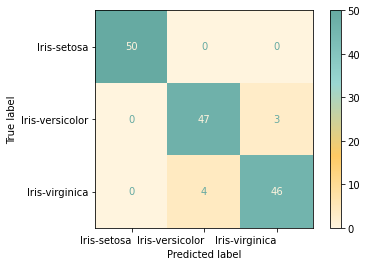

In [14]:
iris_model = GaussianNB()
y_true = np.array([])
y_pred = np.array([])
for train_index, test_index in kf.split(iris_feature):
    x_train_iris, x_test_iris = iris_feature[train_index], iris_feature[test_index]
    y_train_iris, y_test_iris = iris_label[train_index], iris_label[test_index]
    iris_model.fit(x_train_iris, y_train_iris)
    y_true = np.append(y_true, y_test_iris)
    y_pred = np.append(y_pred, iris_model.predict(x_test_iris))
generate_report(y_true, y_pred, iris_le)

## Questions

### $P(X_{stalk−color−below−ring}|Y=e)$ with Laplace smoothing

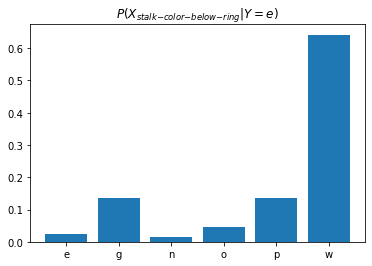

In [15]:
alpha = 1.0
features = mushroom_data['stalk-color-below-ring'][mushroom_data['label'] == 'e'].to_numpy()
feature_type, feature_counts = np.unique(features, return_counts=True)
denominator = len(features) + alpha * len(feature_type)
prob = [(x + alpha) / denominator for x in feature_counts]
fig, ax = plt.subplots()
ax.set_title("$P(X_{stalk−color−below−ring}|Y=e)$")
ax.bar(feature_type, prob)
fig.show()

### $P(X_{stalk−color−below−ring}|Y=e)$ without Laplace smoothing

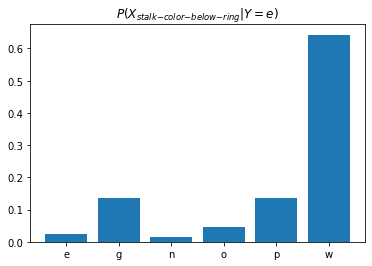

In [16]:
prob = feature_counts / feature_counts.sum()
fig, ax = plt.subplots()
ax.set_title("$P(X_{stalk−color−below−ring}|Y=e)$")
ax.bar(feature_type, prob)
fig.show()

### $P(X_{petal\_length}|Y=Iris\ versicolor)$ $\mu$ and $\sigma$ and PDF

In [17]:
petal_length = iris_data['petal length'][iris_data['label'] == "Iris-versicolor"]

avg = np.average(petal_length)
std = np.std(petal_length)

print('μ = {:.6f} σ = {:.6f}'.format(avg, std))

μ = 4.260000 σ = 0.465188


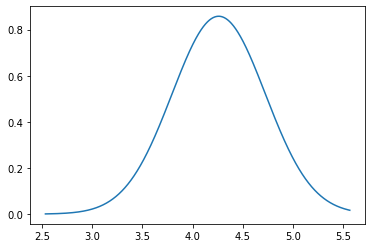

In [18]:
x = np.linspace(petal_length.min() - std, petal_length.max() + std, 10000)
y = norm.pdf(x, avg, std)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.show()